# make_grid:
### Version id:
### GEBCO v2023
### first version.

In [2]:

run ='seqld'
vers='1km'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# # define coordinate transforms
# ## convert convert polarstereo to lat/lon and vice versa.
# from pyproj import Transformer
# from pyproj import CRS
# ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
# ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask

# Set model vertical coordinate settings

N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline


In [3]:
#load GEBCO 2023 geometry

gebco_2023_bed = os.path.join(data_dir,'raw','GEBCO_2023','GEBCO_2023_sub_ice_topo.nc')

g23 = xr.load_dataset(gebco_2023_bed)

g23 = g23.sel(lon=slice(149,160),lat=slice(-30,-21))
g23

long,latg = np.meshgrid(g23.lon,g23.lat)
g23 = g23.assign_coords({"longitude": (("lat", "lon"), long), "latitude": (("lat", "lon"), latg)})

# make bathy: (i.e. +ve downwards); with -ve values set to minimum value; values less than min value == min value
min_bathy_thresh = 0.1
g23['bathy_raw']=-g23.elevation
g23['bathy'] = g23.bathy_raw.where(g23.bathy_raw>=min_bathy_thresh,min_bathy_thresh)

# make masks
g23["mask_ocean"]=np.isfinite(g23.elevation.where(g23.elevation<0,np.NaN))

In [4]:
g23

<xarray.Dataset>
Dimensions:     (lon: 2640, lat: 2160)
Coordinates:
  * lon         (lon) float64 149.0 149.0 149.0 149.0 ... 160.0 160.0 160.0
  * lat         (lat) float64 -30.0 -29.99 -29.99 -29.99 ... -21.01 -21.01 -21.0
    longitude   (lat, lon) float64 149.0 149.0 149.0 149.0 ... 160.0 160.0 160.0
    latitude    (lat, lon) float64 -30.0 -30.0 -30.0 -30.0 ... -21.0 -21.0 -21.0
Data variables:
    elevation   (lat, lon) int16 161 161 162 162 161 ... -2123 -2119 -2116 -2113
    bathy_raw   (lat, lon) int16 -161 -161 -162 -162 ... 2123 2119 2116 2113
    bathy       (lat, lon) float64 0.1 0.1 0.1 ... 2.119e+03 2.116e+03 2.113e+03
    mask_ocean  (lat, lon) bool False False False False ... True True True True
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

<Figure size 640x480 with 0 Axes>

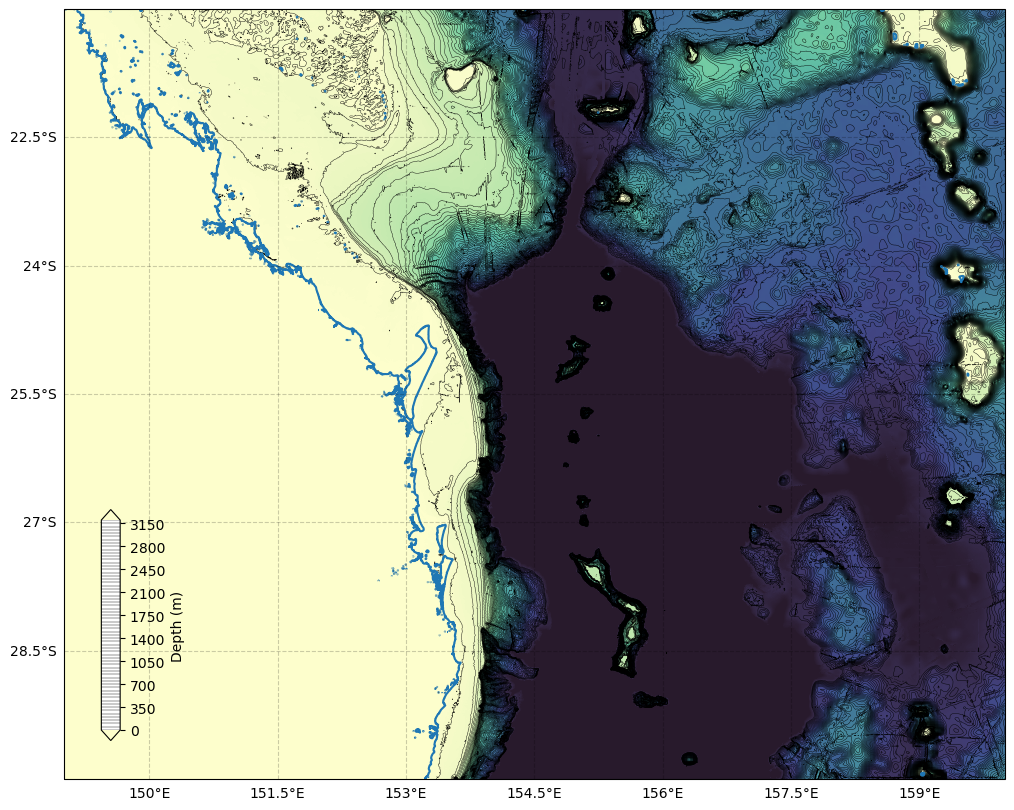

In [5]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = (-g23.elevation).plot.pcolormesh(x='lon',y='lat',cmap='cmo.deep',add_colorbar=False,vmin=0,vmax=3500)
im = (-g23.elevation).plot.contour(x='lon',y='lat',colors='k',linewidths=.3,levels=np.array([*np.arange(00,3250,50)]),add_colorbar=False)
co=plt.contour(g23.lon,g23.lat,g23.elevation,levels=np.array([0]),colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()

In [6]:
mr = 1/100 #deg #1/100 is about 1km res, 1/200 is about 500m res.
grid_xLims= (151.5,159.5) #km
grid_yLims= (-30,-24) #km
Equal2Params=(154,1/15) #lat of first transition, second resolution
Equal3Params=(152.5,1/100,154,1/15) #lat of first transition, second resolution, lat of second transition, third resolution
QuadraticParams=(100,1/10,1/10) #number of cells, res_start, res_end
LinearParams=(601,1/300,1/30) # number of cells (ODD number), res_start, res_end
spacingType = 'Equal'
if spacingType=='Equal':
    #establish the grid with grid point distances of mr/2 in km
    #we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
    #we need an extra line of u and v points at first to calculate all dx and dy on rho points
    x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
    # x_rho = x[1::2,1::2]
    # y_rho = y[1::2,1::2]
elif spacingType=='Linear':
    num_cells = LinearParams[0]
    res_start = LinearParams[1]
    res_end = LinearParams[2]
    xx = grid_xLims[0]+np.cumsum(((np.linspace(grid_xLims[0],grid_xLims[1],num_cells) - grid_xLims[0] )/ (grid_xLims[1]-grid_xLims[0]) ) * (res_end-res_start) + res_start)
    xx = xx[xx<=grid_xLims[1]] # quick hack because it's generating too many points. Need to work out the N value required to end at exactly grid_xLims[1]. Ask maths person?
    plt.plot(xx,'.')
    yy = np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2)
    x,y = np.meshgrid(xx,yy)
elif spacingType=='Equal2Segment':
    xx0 = np.arange(grid_xLims[0],Equal2Params[0]+mr/2,mr/2)
    xx1 = np.arange(Equal2Params[0]+Equal2Params[1]/2,grid_xLims[1]+Equal2Params[1]/2,Equal2Params[1]/2)
    xx = np.hstack([xx0,xx1])
    plt.plot(xx,'.')
    yy = np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2)
    x,y = np.meshgrid(xx,yy)
    x_rho = x[1::2,1::2]
    y_rho = y[1::2,1::2]
elif spacingType=='Equal3Segment':
    xx0 = np.arange(grid_xLims[0],Equal3Params[0]+mr/2,mr/2)
    xx1 = np.arange(Equal3Params[0]+Equal3Params[1]/2,Equal3Params[2],Equal3Params[1]/2)
    xx2 = np.arange(Equal3Params[2]+Equal3Params[3]/2,grid_xLims[1]+Equal3Params[3]/2,Equal3Params[3]/2)
    xx = np.hstack([xx0,xx1,xx2])
    plt.plot(xx,'.')
    yy = np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2)
    x,y = np.meshgrid(xx,yy)
    x_rho = x[1::2,1::2]
    y_rho = y[1::2,1::2]
elif spacingType=='Quadratic':   
    num_steps = QuadraticParams[0]
    res_start = QuadraticParams[1]  # Initial resolution
    res_end = QuadraticParams[2]  # Final resolution

    ratios = np.linspace(0, 1, num_steps)
    resolutions = res_start + ratios**2 * (res_end - res_start)
    # xx = np.cumsum(resolutions) * (grid_xLims[1] - grid_xLims[0]) + grid_xLims[0]
    xx = resolutions/resolutions.max()*(grid_xLims[1]-grid_xLims[0]) + grid_xLims[0]
    plt.plot(xx,'.')
    yy = np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2)
    x,y = np.meshgrid(xx,yy)
    x_rho = x[1::2,1::2]
    y_rho = y[1::2,1::2]


# # display some basic grid metrics

#calculate curvilinear coordinate distances at rho points
dx = haversine(x[1::2,0:-2:2],y[1::2,0:-2:2],x[1::2,2::2],y[1::2,2::2])
dy = haversine(x[0:-2:2,1::2],y[0:-2:2,1::2],x[2::2,1::2],y[2::2,1::2])

print('dx min/max/mean (m): ',dx.min(),dx.max(),dx.mean())
print('dy min/max/mean (m): ',dy.min(),dy.max(),dy.mean())

print('grid size, (xi,eta):',dx.shape)

# mask = geom.mask_ocean.astype(float).values
mindxy = min(np.hstack((dx.flatten(),dy.flatten())))
# maskNaN = mask.copy()
# maskNaN[mask==0]=np.nan


print('max slow DT in s following CFL: ', np.nanmin(mindxy/8)) # approx max 8m/s baroclinic wave speed

dx min/max/mean (m):  963.0248264260878 1015.7767293613398 990.3014126035558
dy min/max/mean (m):  1111.9492664448107 1111.949266445518 1111.949266445365
grid size, (xi,eta): (600, 800)
max slow DT in s following CFL:  120.37810330326097


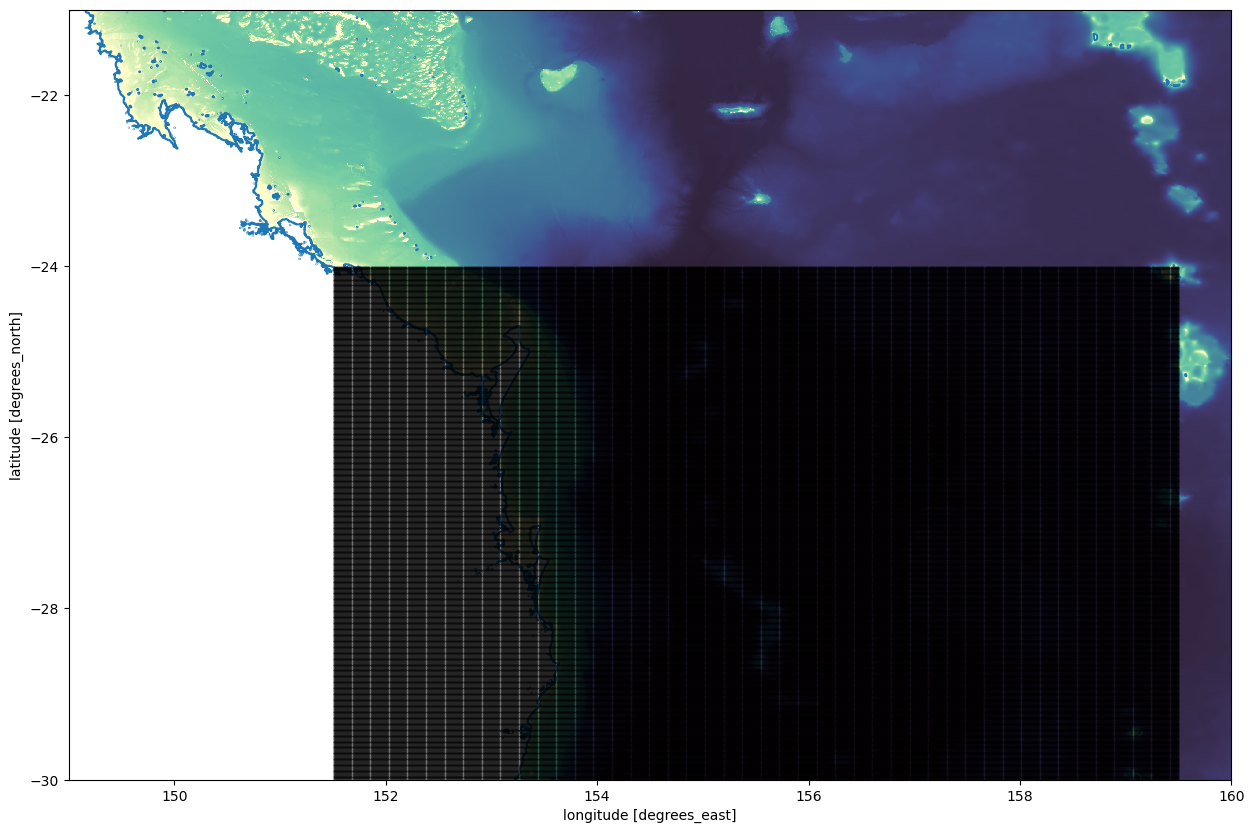

In [7]:
import matplotlib.colors as colors
fig=plt.figure(figsize=(15,10))
im = (-g23.elevation).plot.pcolormesh(x='lon',y='lat',cmap='cmo.deep',add_colorbar=False,norm=colors.LogNorm(10, 5000))
co=plt.contour(g23.lon,g23.lat,g23.elevation,levels=np.array([0]),colors='C0')

plt.plot(x[1::2,1::2],y[1::2,1::2],'.',color='k',markersize=.5)


In [8]:
#Control on whether to continue with grid making
ShouldContinue=True
if ShouldContinue:
    print('Continuing..')
else:
    STOP

Continuing..


In [9]:

lat,lon = y,x

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

## Begin interpolation from raw data to constructed grid

In [10]:
# interpolate the raw data field bathy, mask_ocean to the new lon_rho, lat_rho

geom = g23

In [11]:
# raw data coordinates
lat_s = geom.latitude.values.flatten()
lon_s = geom.longitude.values.flatten()

In [12]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated mask_ocean


<Figure size 640x480 with 0 Axes>

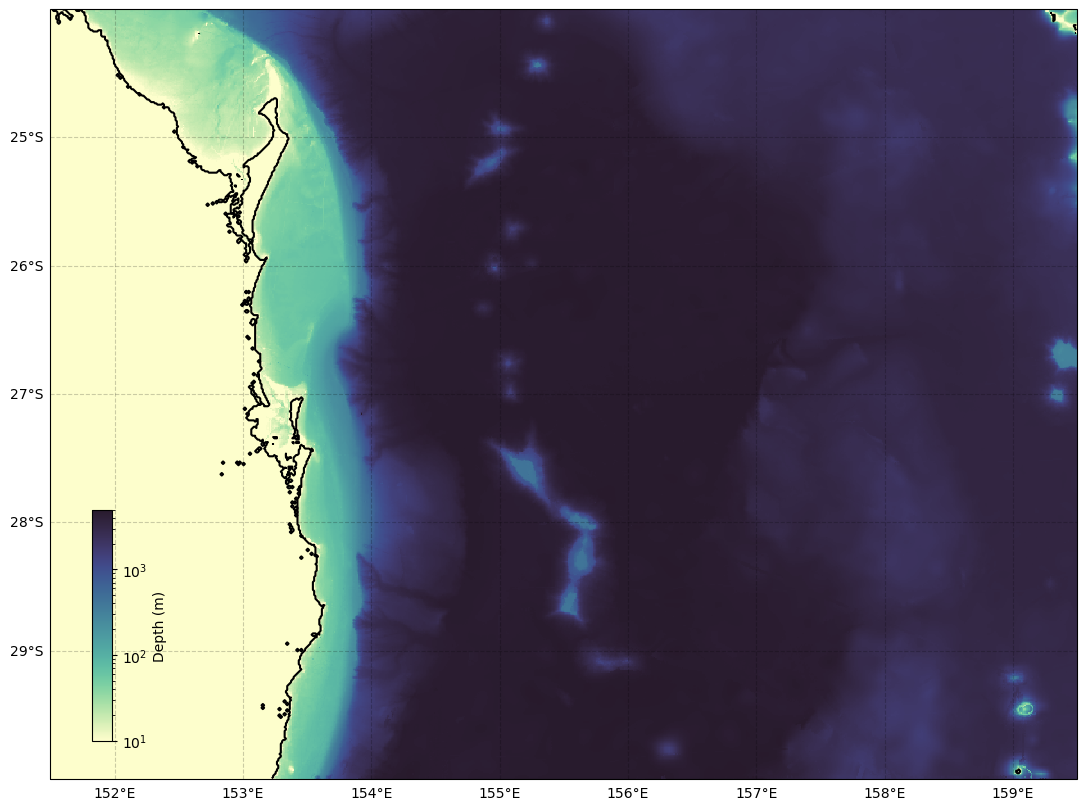

In [13]:
# Create a plot of the interpolated first-cut model bathymetry data using Cartopy

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'],cmap='cmo.deep',norm=colors.LogNorm(10, 5000))
co = plt.contour(lon_rho,lat_rho,roms_tmp['bathy'],levels=np.array([0.1]),colors='k')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


dx min/max/mean (m):  1964.0 1973.0 1968.0
dy min/max/mean (m):  2224.0 2224.0 2224.0


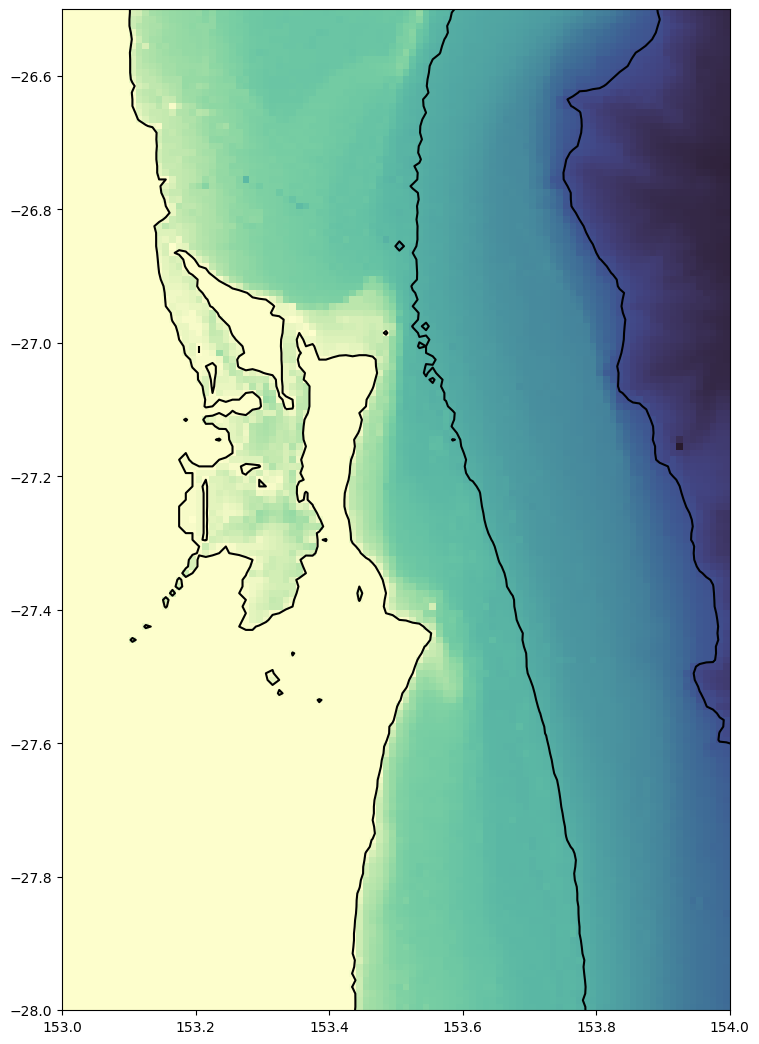

In [14]:
# plot of chosen subset
fig,ax=plt.subplots(figsize=(20,13))
im = plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'],cmap='cmo.deep',norm=colors.LogNorm(10, 5000))
co = plt.contour(lon_rho,lat_rho,roms_tmp['bathy'],colors='k',levels=np.array([0,10,100,1000]))
ax.set_aspect('equal','box')
ax.axis([153,154, -28,-26.5])

_sel = (lon_rho>153)&(lon_rho<154)&(lat_rho>-28)&(lat_rho<-27.5)
_sel = _sel*1.0
_sel[_sel==False]=np.NaN

sublon = lon_rho*_sel
sublat = lat_rho*_sel

dxx = haversine(sublon[1::2,0:-2:2],sublat[1::2,0:-2:2],sublon[1::2,2::2],sublat[1::2,2::2])
dyy = haversine(sublon[0:-2:2,1::2],sublat[0:-2:2,1::2],sublon[2::2,1::2],sublat[2::2,1::2])


print('dx min/max/mean (m): ',np.nanmin(dxx).round(),np.nanmax(dxx).round(),np.nanmean(dxx).round())
print('dy min/max/mean (m): ',np.nanmin(dyy).round(),np.nanmax(dyy).round(),np.nanmean(dyy).round())

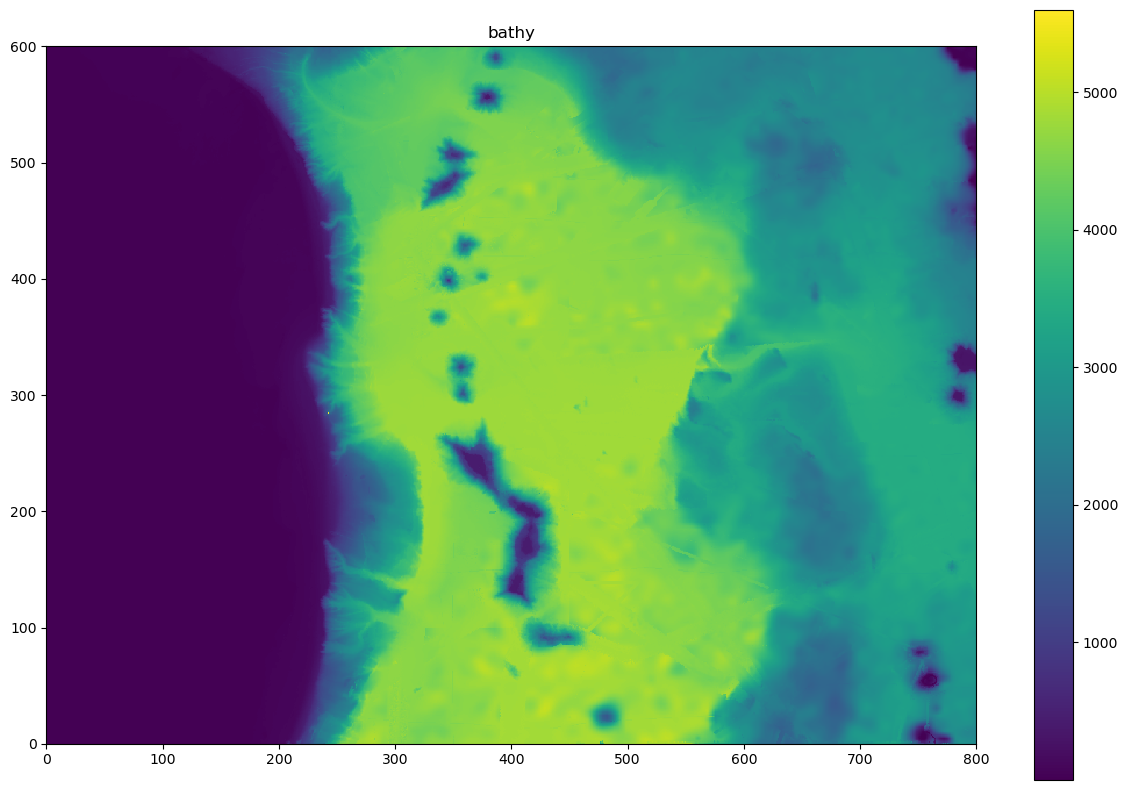

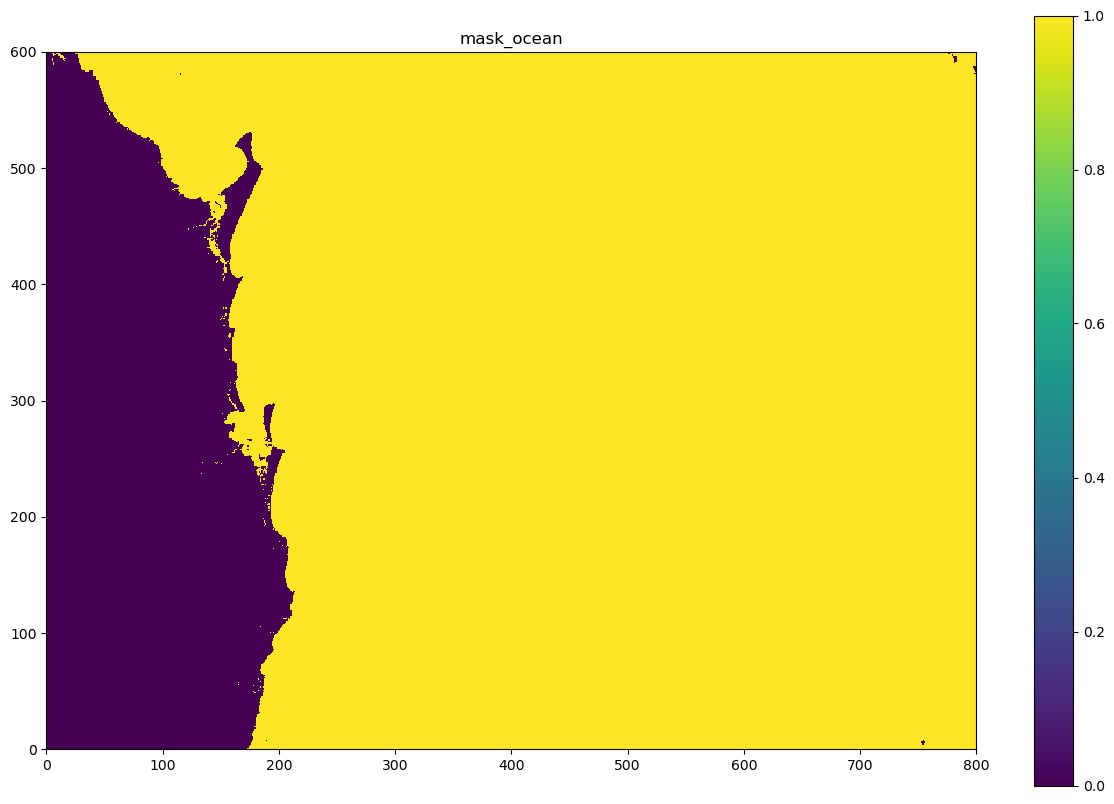

In [15]:
plotting=True

if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

  
Minimum r-value =  0.0
Maximum r-value =  0.9759036144578314
Mean    r-value =  0.014467191237182108
Median  r-value =  0.002221728504776716


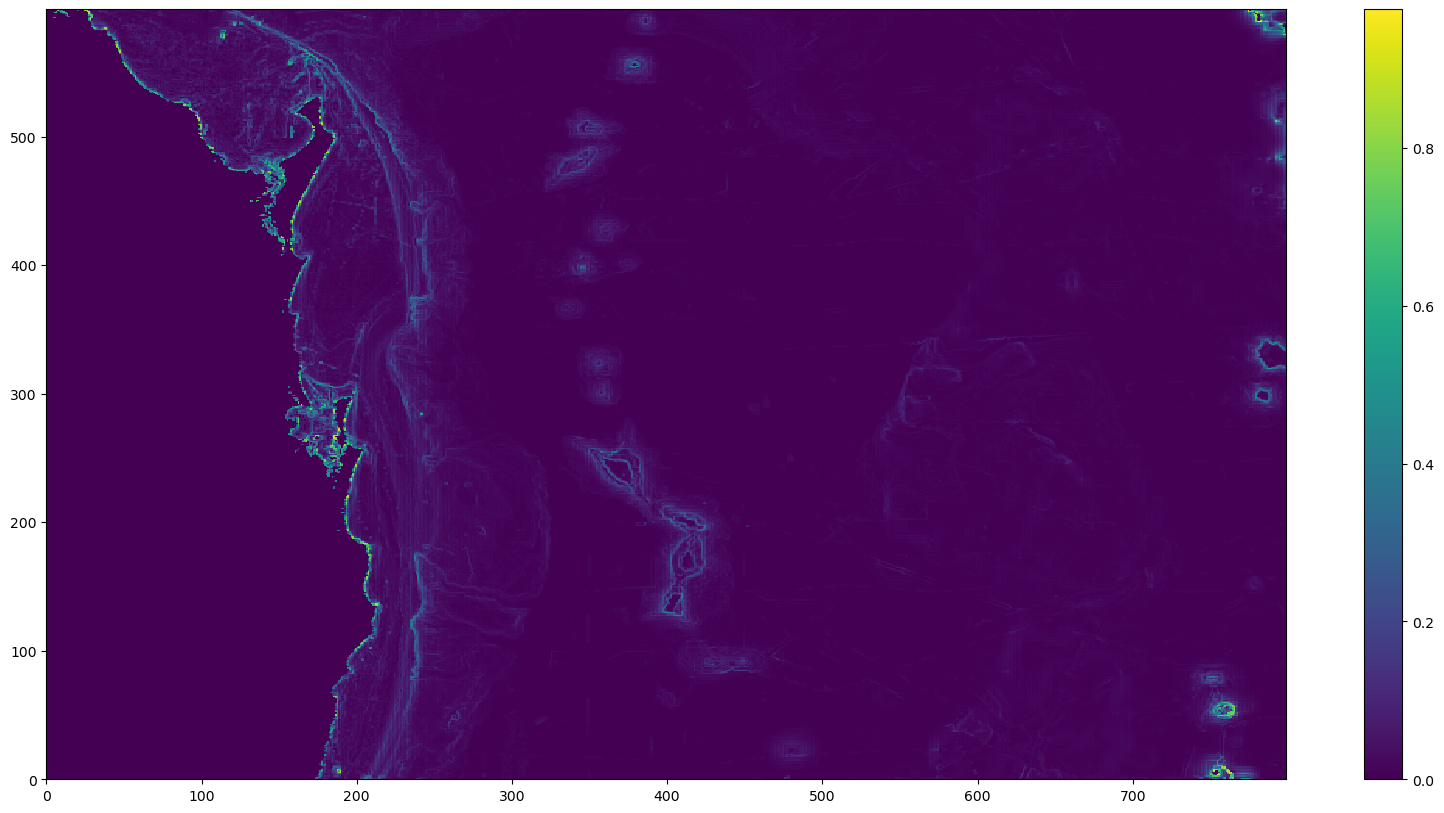

  
Minimum r-value =  0.0
Maximum r-value =  153.25298429047305
Mean    r-value =  2.1615793745927894
Median  r-value =  0.5762515029732026


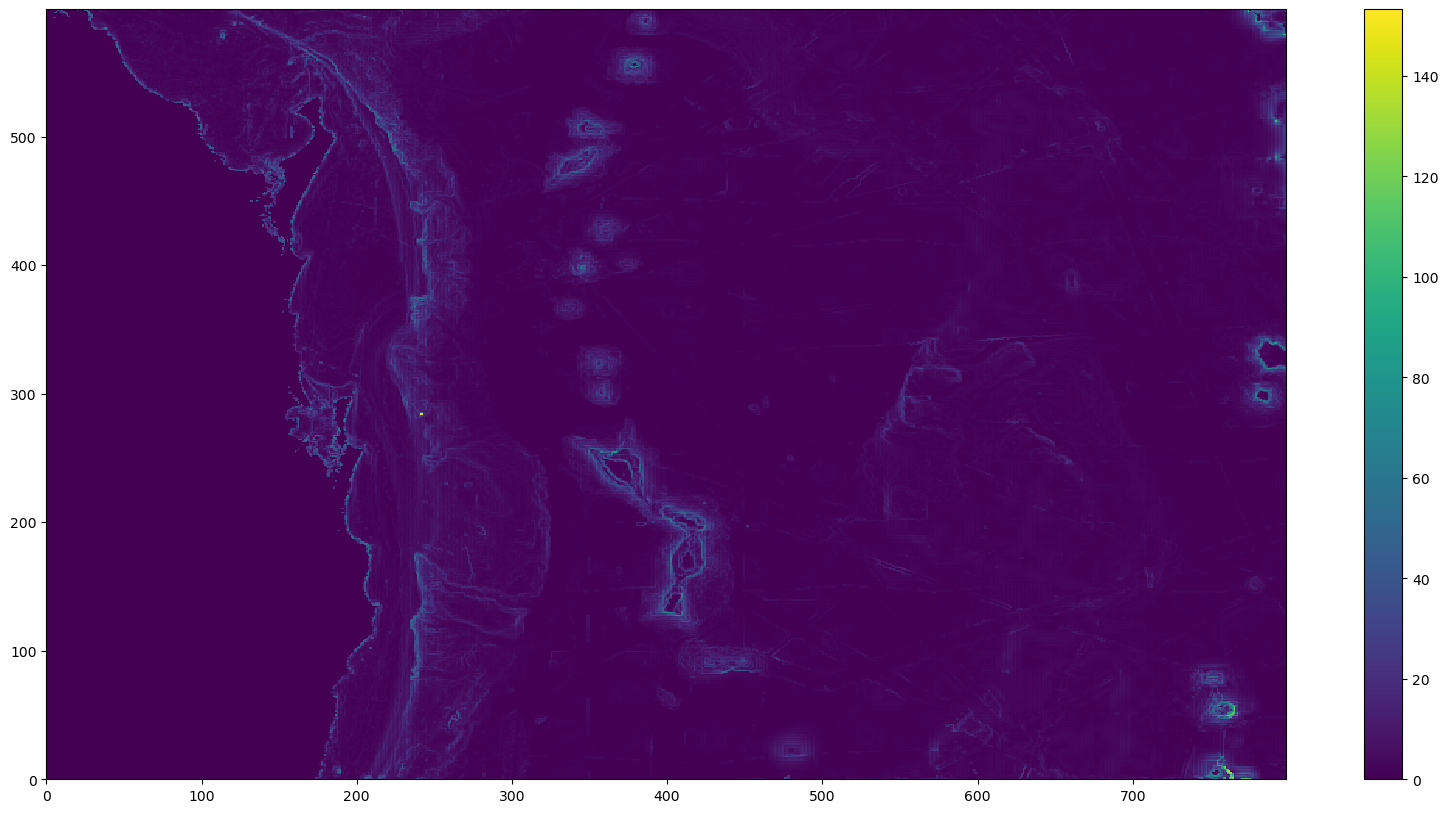

In [16]:


z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],np.zeros(roms_tmp['bathy'].shape))


fig = plt.figure(figsize=(20,10))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

In [17]:
# do checks
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())


min/max h is 0.1 / 5597.0


In [18]:
# First round of smoothing

bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']

mask = roms_tmp['mask_ocean']
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
min_depth0=0.1
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# reduce/cap the max bathy to increase CFL speed
max_depth=4000
bed[bed>max_depth]=max_depth



# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
rx0in = 0.3
max_iter = 100

Area = 1/(pm*pn)

bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(bed),bed,rx0in,Area,max_iter)


Old Max Roughness value is:  0.9989696032972695


DeltaBathymetry =  -0.5
New Max Roughness value is:  0.3000043971251753


In [19]:
# do checks
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))


min/max h is 0.33106937666262226 / 4000.0


In [20]:
# now apply the actual minimum water column thickness
min_depth=10.0

bed_smooth1 = bed.copy()

bed[bed < min_depth] = min_depth


In [21]:
# do checks

print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))


min/max h is 10.0 / 4000.0


  
Minimum r-value =  0.0
Maximum r-value =  0.3000000447279074
Mean    r-value =  0.011069471473759931
Median  r-value =  0.0


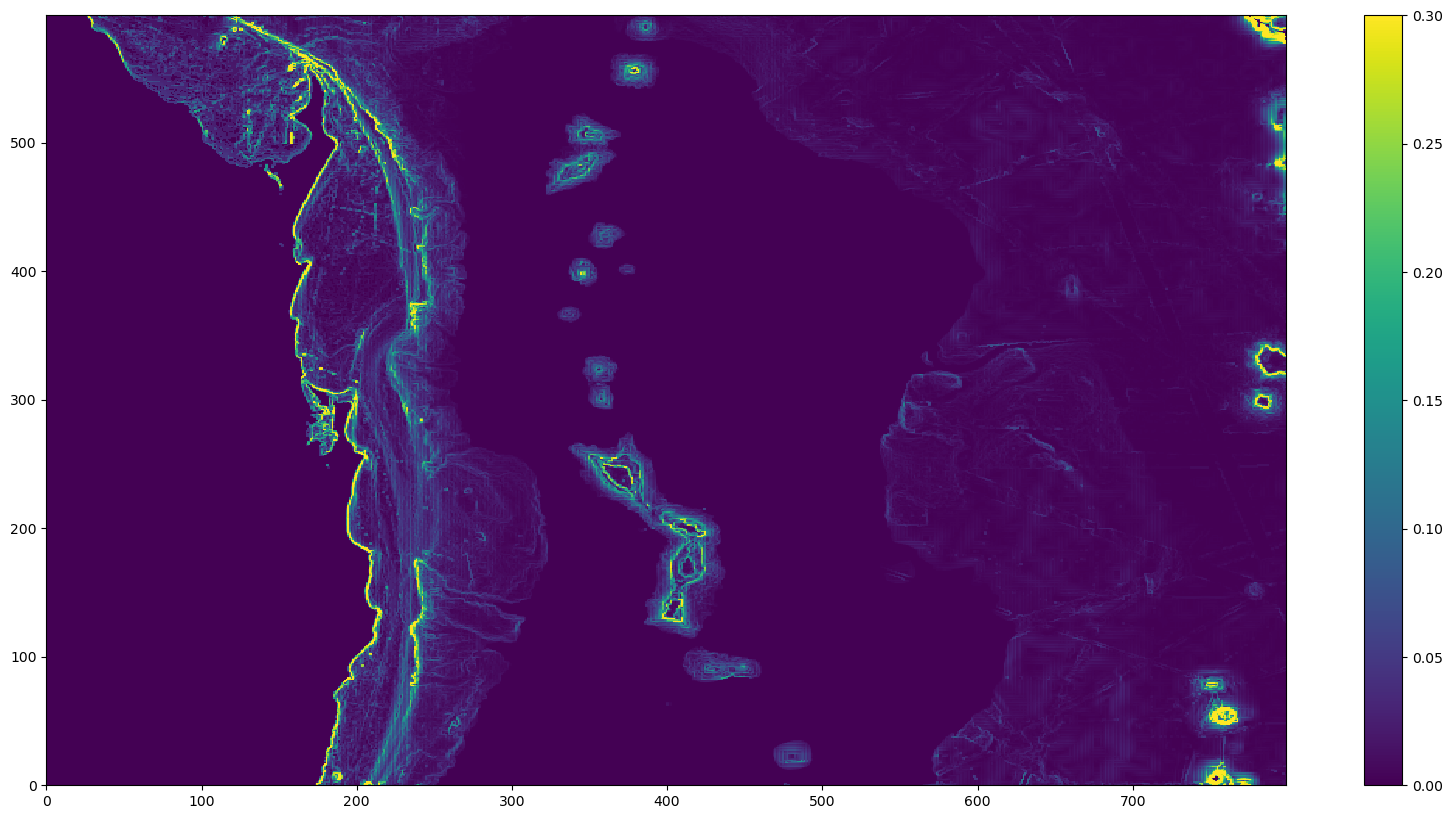

  
Minimum r-value =  0.0
Maximum r-value =  72.88060769252385
Mean    r-value =  1.722066453113649
Median  r-value =  0.0


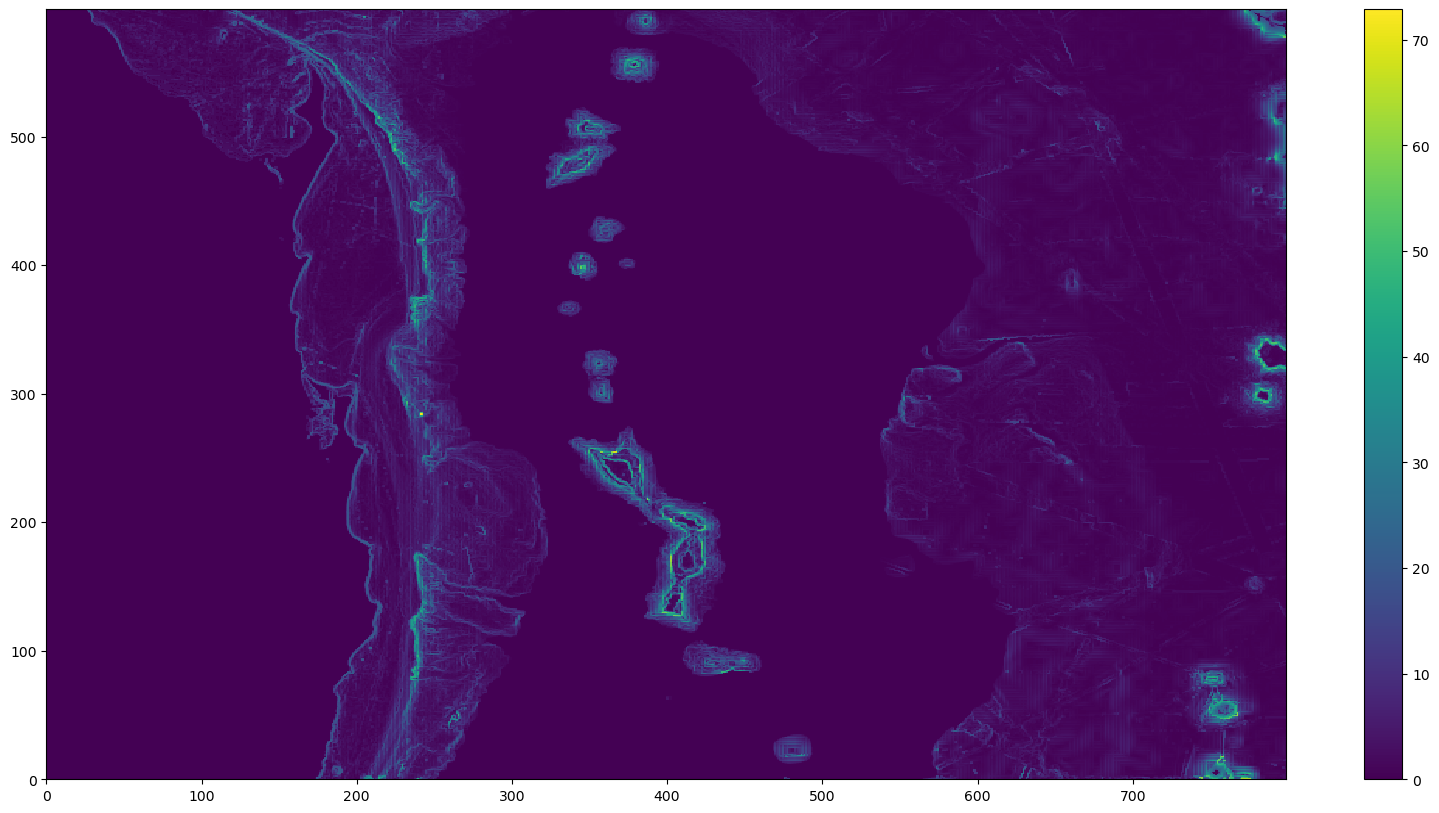

In [22]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,np.zeros(roms_tmp['bathy'].shape))

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()


In [23]:
# Second round of smoothing 
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,rx0in,Area,max_iter)

bed_smooth2 = bed.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed) < min_depth) & (mask == 1)
bed[ii] = min_depth

# do the same for all non-ocean points
ii = ((bed) < min_depth) & (mask == 0)
bed[ii] = min_depth # for those locations, the depth needs to be min_depth above the bathy


Old Max Roughness value is:  0.3000000447279074


DeltaBathymetry =  0.0
New Max Roughness value is:  0.3000000447279074


In [24]:
# update values in roms_tmp

roms_tmp['bed'] = bed
roms_tmp['mask'] = mask

bathy


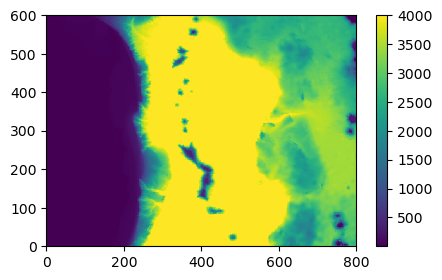

mask_ocean


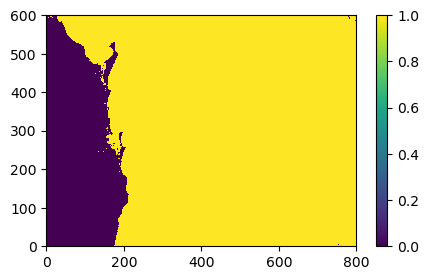

bed


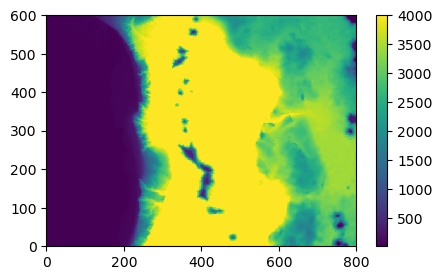

mask


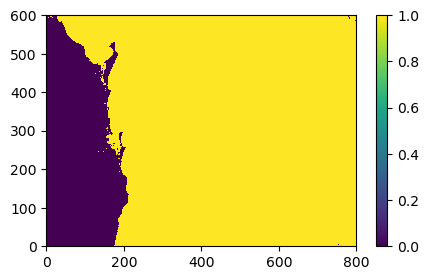

In [25]:
if plotting:
    plt.close()
    for k,v in roms_tmp.items():
        plt.figure(figsize=(5,3))
        print(k)
        plt.pcolormesh(v)
        plt.colorbar()
        plt.show()

In [26]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*bed))*maskNaN

print('minimum dx/dy (m): ',mindxy)
print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

minimum dx/dy (m):  963.0248264260879
max fast DT in s following CFL:  4.861530154304082
max slow DT in s following CFL:  120.37810330326099
Set ROMS timestep settings of at least: 
 DT < 120.37810330326099 s 
 NDTFAST > 25.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  2.1751613323759584
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.21751613323759583


In [27]:
# do checks
print('whole domain')
print('min/max h is',bed.min(),'/',bed.max())
print('ocean cells')
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))


whole domain
min/max h is 10.0 / 4000.0
ocean cells
min/max h is 10.0 / 4000.0


  
Minimum r-value =  0.0
Maximum r-value =  0.3000000447279074
Mean    r-value =  0.011069471473759931
Median  r-value =  0.0


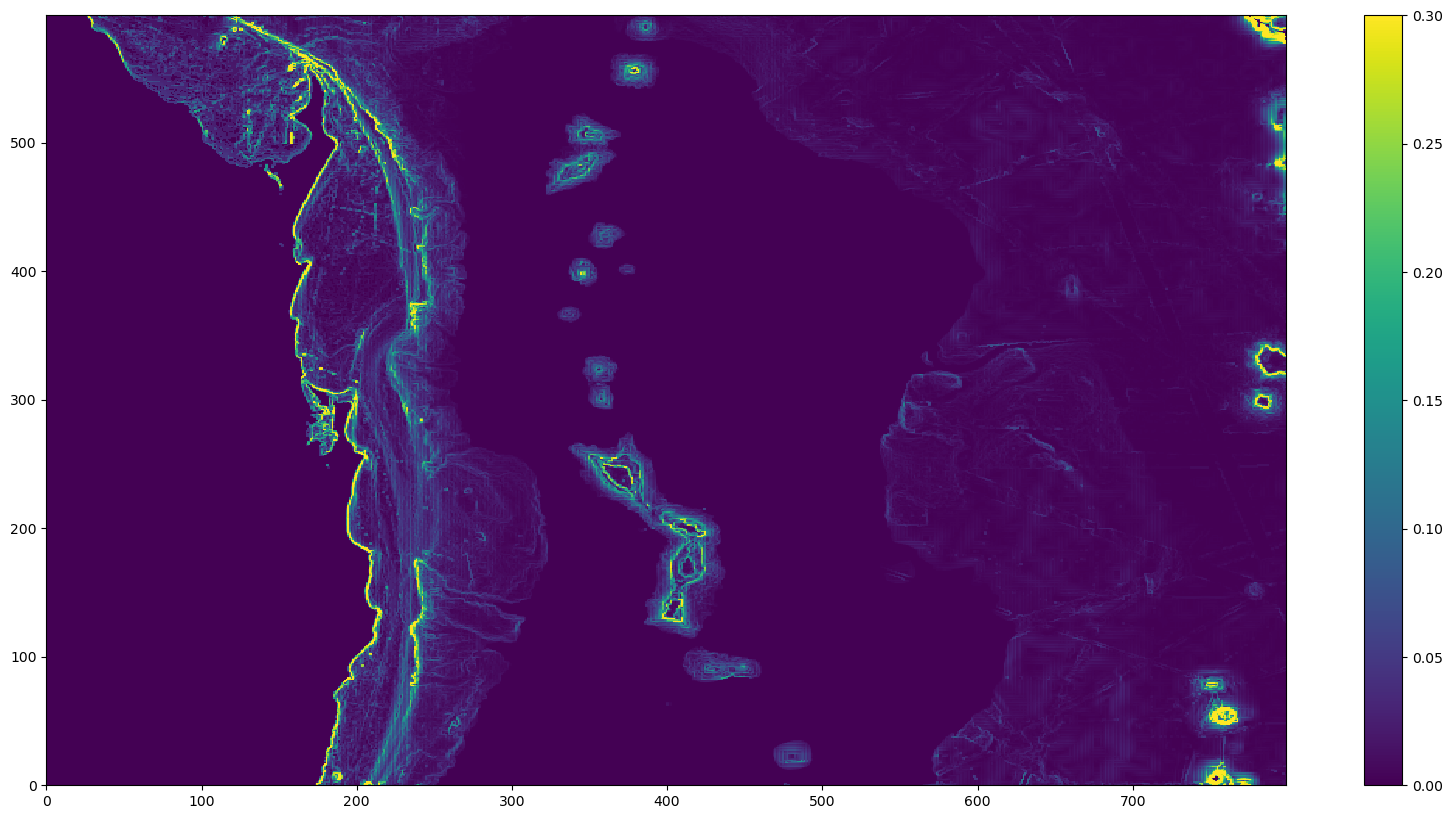

  
Minimum r-value =  0.0
Maximum r-value =  72.88060769252385
Mean    r-value =  1.722066453113649
Median  r-value =  0.0


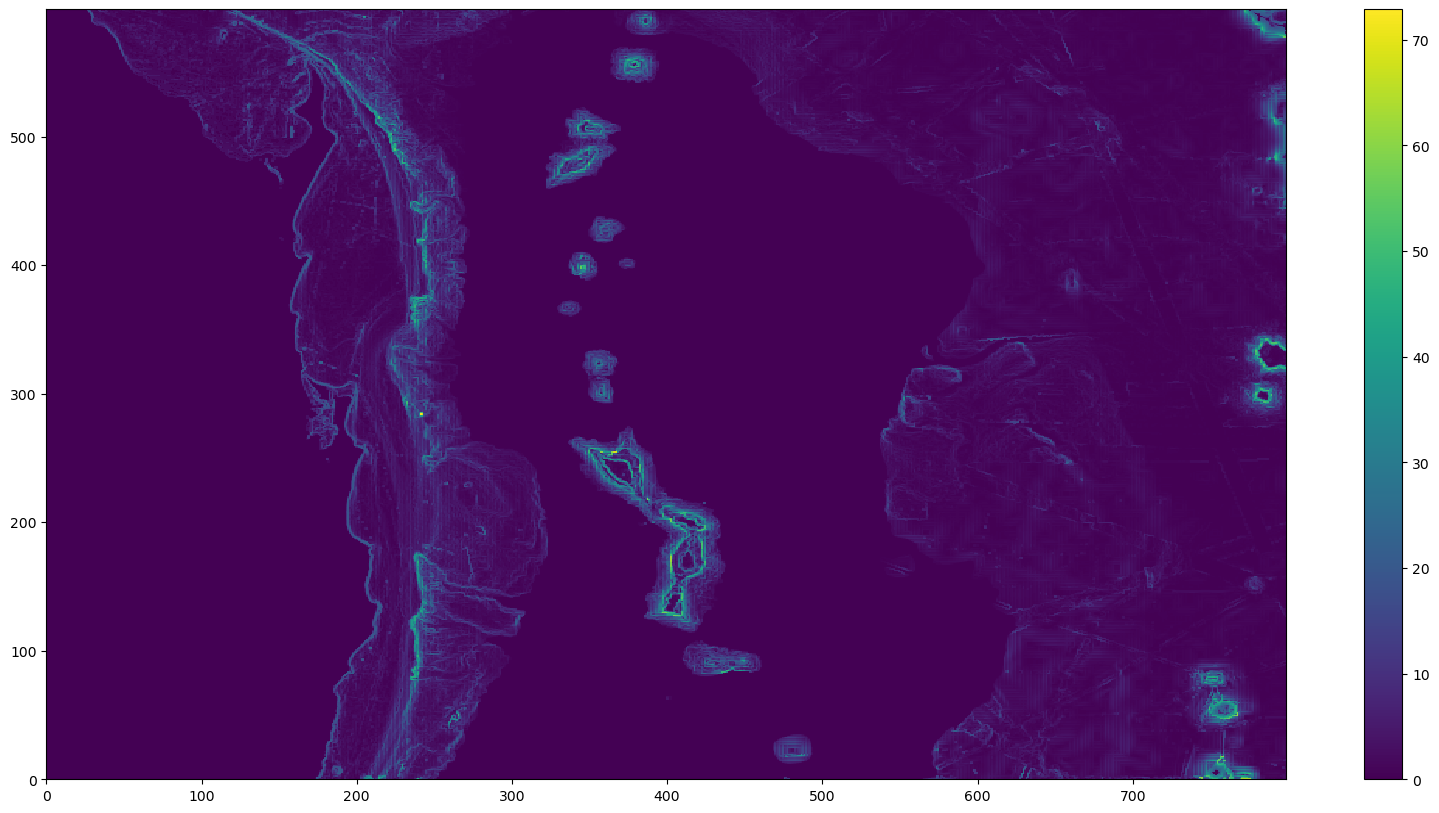

In [28]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],np.zeros(roms_tmp['bed'].shape))

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()


In [1]:
handEditing=True
if handEditing:
    # !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING GEOMETRY. HERE BE DRAGONS. !!!
    # ensure that GridAdjustments functions are already loaded.

    focusRange=(100,120,340,360)
    seeBigPicture=True
    searchForValrx1=70
    # fig = plt.figure(figsize=(20,10))
    # plt.pcolormesh(grd_rx1_post)
    # plt.colorbar()
    # plt.grid()
    # plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
    # plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
    # plt.xlim(focusRange[0],focusRange[1])
    # plt.ylim(focusRange[2],focusRange[3])
    # plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.pcolormesh((roms_tmp['bed'])*maskNaN,vmax=100)
    plt.grid()
    plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
    plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1),rotation=45)
    # plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
    plt.colorbar()
    plt.xlim(focusRange[0],focusRange[1])
    plt.ylim(focusRange[2],focusRange[3])
    plt.show()


    # plt.plot(-roms_tmp['bed'][:,396],'.-')
    # plt.plot(roms_tmp['ice'][:,396],'.-')
    # plt.plot(-1*roms_tmp['mask'][:,396]*2500,'.-')
    # plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
    # plt.yticks(np.arange(-3500,0,200))
    # plt.xlim(220,260)
    # plt.grid()
    # plt.show()


    hhh=roms_tmp['bed'].copy()
    mmm=roms_tmp['mask'].copy()

    # # remove a long string of very thin very steep border cells (basically cells on the edge of a subglacial mountain side; see above plots of bedrock)
    # mmm=adjustMask(mmm,0,eta=347,xi=112)
    # hhh,zzz=adjustWCT(hhh,zzz,h_alter=300,zice_alter=-300,eta=351,xi=slice(94,96))
    # mmm=adjustMask(mmm,0,eta=361,xi=slice(95,97))
 
    # # tweak water column bordering on edge of mountain range on eastern GL.
    # hhh,zzz=adjustWCT(hhh,zzz,h_alter=250,zice_alter=-150,eta=348,xi=112)
    # mmm=adjustMask(mmm,0,eta=328,xi=212)
   


    # # tweak water column bordering on barely grounded western mid shelf.
    # mmm=adjustMask(mmm,0,eta=slice(379,383),xi=slice(181,189))
    # mmm=adjustMask(mmm,0,eta=slice(381,383),xi=slice(179,181))
  
    # # tweak water column bordering on weird ear shaped area on western mid shelf.
    # mmm=adjustMask(mmm,0,eta=slice(417,421),xi=slice(259,266))
    # mmm=adjustMask(mmm,0,eta=415,xi=slice(271,274))
   


    mmmNaN = mmm.copy().astype('float')
    mmmNaN[mmmNaN == 0] = np.NaN

    fig = plt.figure(figsize=(20,10))
    plt.pcolormesh((roms_tmp['bed'])*mmmNaN)
    plt.grid()
    plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
    plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1),rotation=45)
    # plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
    plt.colorbar()
    plt.xlim(focusRange[0],focusRange[1])
    plt.ylim(focusRange[2],focusRange[3])
    plt.show()

    # look along a single xi value
    lookAt=260
    plt.plot(-hhh[:,lookAt],'.-')
    plt.plot(-1*mmm[:,lookAt]*2500,'.-')
    plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
    plt.yticks(np.arange(-3500,0,200))
    plt.xlim(focusRange[2],focusRange[3])
    plt.grid()
    plt.show()

    # look along a single eta value
    lookAt=320
    plt.plot(-hhh[lookAt,:],'.-')
    plt.plot(-1*mmm[lookAt,:]*2500,'.-')
    plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
    plt.yticks(np.arange(-3500,0,200))
    plt.xlim(focusRange[0],focusRange[1])
    plt.grid()
    plt.show()



    z_rho_test,z_w_test,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,np.zeros(roms_tmp['bed'].shape))
    grd_rx1_test=GridStiffness.rx1(z_w_test,mmm)
    max_vals_vals=grd_rx1_test[grd_rx1_test>searchForValrx1]
    max_vals_y,max_vals_x=np.nonzero(grd_rx1_test>searchForValrx1)
    print(max_vals_vals.shape)
    fig = plt.figure(figsize=(30,20))
    plt.pcolormesh(grd_rx1_test)
    plt.grid()
    plt.plot(max_vals_x,max_vals_y,'ro')

    if seeBigPicture==False:
        plt.yticks(np.arange(1,750,1),np.arange(1.5,750,1))
        plt.xticks(np.arange(1,900,1),np.arange(1.5,900,1),rotation=45)
        plt.xlim(focusRange[0],focusRange[1])
        plt.ylim(focusRange[2],focusRange[3])
    else:
        plt.yticks(np.arange(1,750,25),np.arange(1,750,25))
        plt.xticks(np.arange(1,900,25),np.arange(1,900,25))
        for x,y,t in zip(max_vals_x,max_vals_y,max_vals_vals):
            plt.text(x,y,str(x)+','+str(y)+','+str(round(t)),ha='left',fontsize=16)
    plt.colorbar()
    plt.show()


NameError: name 'plt' is not defined

In [30]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mask)

mmm_noSS = mask.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mask = mmm_noSS

In [31]:

# fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

# ax = axs[0,0]
# ax.pcolormesh(grd_rx0_pre,vmax=1)
# ax.set_title('rx0',fontsize=16)
# ax.set_ylabel('pre-smoothing',fontsize=16)
# ax = axs[0,1]
# grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
# ax.pcolormesh(grd_rx1_pre,vmax=1500)
# ax.set_title('rx1',fontsize=16)
# ax = axs[1,0]
# im=ax.pcolormesh(grd_rx0_post,vmax=1)
# plt.colorbar(im,ax=axs[:,0],shrink=0.6)
# ax.set_ylabel('post-smoothing',fontsize=16)
# ax = axs[1,1]
# im=ax.pcolormesh(grd_rx1_post,vmax=1500)
# plt.colorbar(im,ax=axs[:,1],shrink=0.6)

# plt.savefig('../out/pre_post_rxVals.png')

In [32]:
# # calculate final rx0 and rx1 values, check that you're happy before overwriting these
# z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
# grd_rx0_final=GridStiffness.rx0(hhh,mmm)

# grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)


In [33]:
# # third round of smoothing, pulling rx0 down to something more reasonable
# hhh_final, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),hhh,rx0in,Area,max_iter)
# zzz_final = zzz.copy()
# # now re-check that min_depth is obeyed for all ocean points
# ii = ((hhh_final + zzz_final) < min_depth) & (mask == 1)
# hhh_final[ii] = -zzz_final[ii] + min_depth

# # do the same for all non-ocean points
# ii = ((hhh_final + zzz_final) < min_depth) & (mask == 0)
# zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy


In [34]:
# # remove any zice that is >0.
# zzz_final_backup = zzz_final.copy()

# anyPosZice=np.any(zzz_final>0)

# if anyPosZice:
#     new_ice = zzz_final.copy()
#     new_ice[(zzz_final>0)]=0
#     zzz_final=new_ice.copy()


In [35]:
# maskNaN = mmm.copy().astype('float')
# maskNaN[maskNaN == 0] = np.NaN

# print('whole domain')
# print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
# print('min/max h is',hhh_final.min(),'/',hhh_final.max())
# print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
# print('ocean cells')
# print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
# print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
# print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

In [36]:
# # calculate final rx0 and rx1 values, check that you're happy before overwriting these
# z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh_final,zzz_final)
# grd_rx0_final=GridStiffness.rx0(hhh_final,mmm)

# grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)



In [37]:
# fig = plt.figure(figsize=(30,20))
# plt.pcolormesh(grd_rx1_final)
# plt.colorbar()
# max_vals_y,max_vals_x=np.nonzero(grd_rx1_final>300)
# max_vals_vals=grd_rx1_final[grd_rx1_final>300]
# plt.plot(max_vals_x,max_vals_y,'ro')
# plt.xlim(80,140)
# plt.ylim(325,375)
# print(max_vals_vals)


In [38]:
# # if happy with above, update hhh
# hhh = hhh_final.copy()
# zzz = zzz_final.copy()

In [39]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=False
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh.copy()
    roms_tmp['ice']=zzz.copy()
    roms_tmp['mask']=mmm.copy()
    
    bed = hhh.copy()
    ice = zzz.copy()
    mask = mmm.copy()


In [40]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max h is',bed.min(),'/',bed.max())
print('ocean cells')
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))


whole domain
min/max h is 10.0 / 4000.0
ocean cells
min/max h is 10.0 / 4000.0


In [41]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*bed))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  4.861530154304082
max slow DT in s following CFL:  120.37810330326099
Set ROMS timestep settings of at least: 
 DT < 120.37810330326099 s 
 NDTFAST > 25.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  2.1751613323759584
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.21751613323759583


Im really not sure if this is correct!


Text(0.5, 1.0, 'angle [converted to degrees] between XI-axis and EAST')

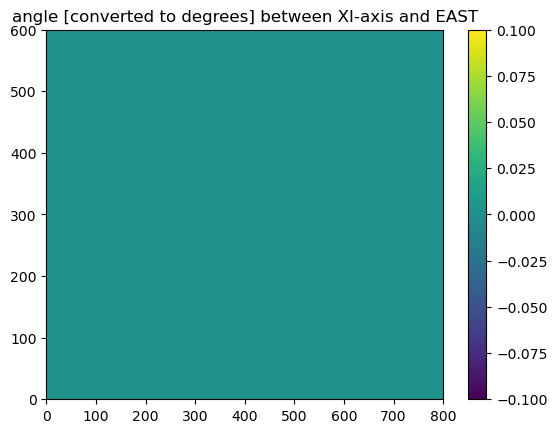

In [47]:
# Calculate the grid angle. !Important!

# angle = lon_rho/180.0*np.pi
# ^^ only works for the polar stereographic grid of the Ole style WAOM model.

# From Charles James GridBuilder:

_,dxdxi = np.gradient(lon_rho)
_,dydxi = np.gradient(lat_rho)

angle = np.arctan2(dydxi,dxdxi)
print('I''m really not sure if this is correct!')

plt.pcolormesh(np.rad2deg(angle))
plt.colorbar()
plt.title('angle [converted to degrees] between XI-axis and EAST')


In [50]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

# angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})


lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                # 'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [55]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/se-qld-setup/data/proc/seqld_1km_grd.nc
